### Test the dataset maker and train a model using a FastAI learner
- starts by building an opensoundscape AudioFileDataset. This is a dataset of file paths and split times, paired with presence/absence labels. By default the AudioFileDataset exposes an AudioSample object when indexed into. The `data` and `labels` properties contain the tensors.
- Uses opensoundscape collate function with fastai dataloaders to collate batches of tensor data and labels. 
- The resulting dataloaders object is passed to a FastAI learner for training. 
- Currently a resnet18 model is used, but this can be swapped out for different pretrainied architectures to leverage transfer learning.


In [1]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import torch
import timm

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load the raw dataframe
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "train_set.pkl")
df_train.head(2)

,Unnamed: 0,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1,1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87956,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac
2,1758,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87898,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac


### Take a sample of the recordings
Training loop is slow with all the data - use a sample to speed things up. 
Sample at the recording level

In [3]:
sample_fraction = 0.1
import random
unique_recordings = list(set(df_train.recording_id))
sample_size = round(sample_fraction * len(unique_recordings))
sample_recordings = random.sample(unique_recordings, sample_size)
df_train_sample = df_train[df_train.recording_id.isin(sample_recordings)]
df_train_sample.shape, df_train.shape

((43029, 70), (432974, 70))

57 not downloaded
downloading 0 clips
skipped 0 previously downloaded files


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/data/build.py:170: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.drop(df.loc[df.target_presence == False][df.target_absence == False].index)


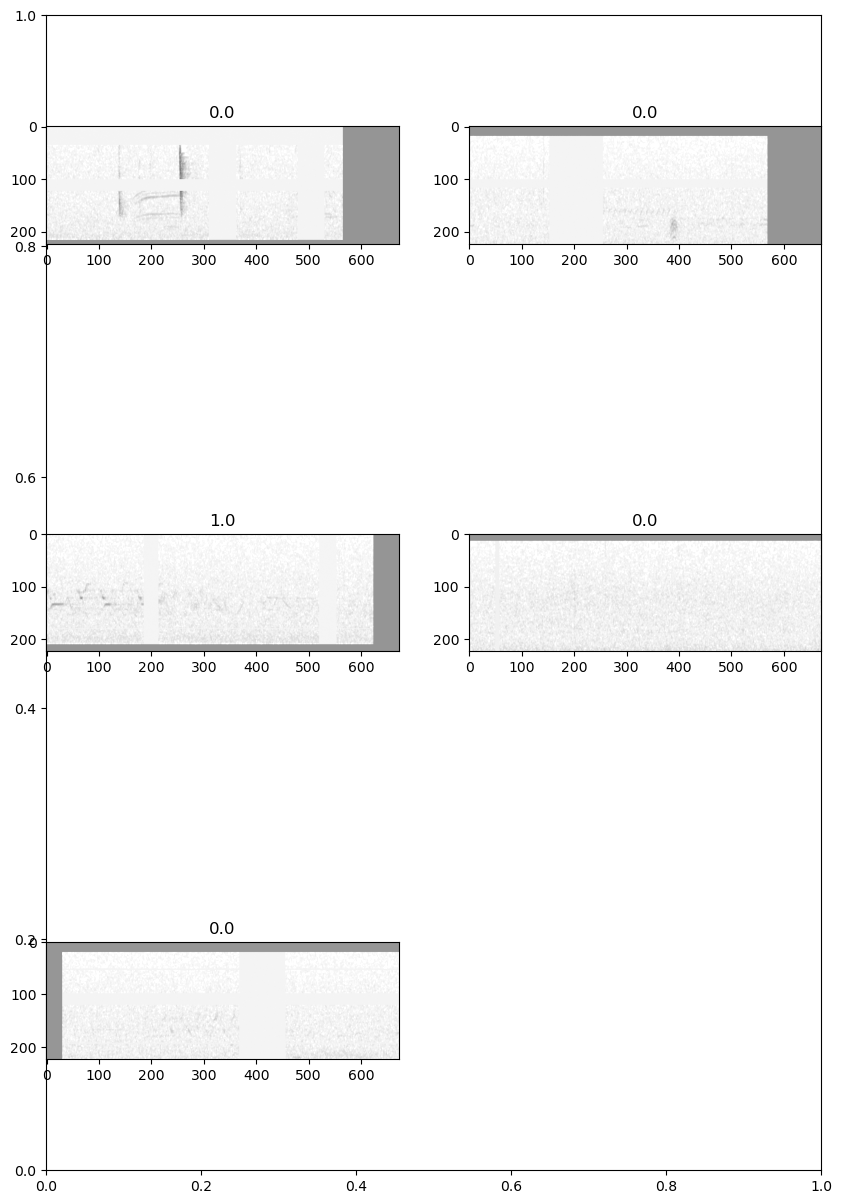

In [4]:
# Turn dataframe into an AudioFileDataset 
train_dataset, valid_dataset = src.data.build.dataset_from_df(df_train_sample, target_species = "OSFL", download_n=0, one_class=False)

In [5]:
train_dataset.label_df.sample()

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-292651.mp3,6.0,9.0,0.0,1.0


## Resample the dataframes in the AudioFileDataset to get fewer no-call samples
Training set is huge, and training is very slow. If we take a sample, then we'll reduce the number of positive labels in the dataset, which is something we might want to avoid, especially for rarer species or under represented classes. Since there's an abundance of the absent class, undersampling this class might be a better approach. 

If we do just undersample the absent class, and if most of these samples are absent of any bird calls (target or non-target species), then there's a possibility the recognizer ends up being a bird / no bird recognizer and doesn't learn species specific features. So we might also arrange the presence of a certanin proportion of non-target bird vocalizations in the training dataset. 

In [6]:
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([ 293., 2933.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([ 89., 862.])))

### Keep a record of the undersampling ratio for use in the loss function during training
If we downsample the abundant class, then it can be upweighted durning training. The downsampled class can be weighted so that loss function sees it as n times more relevant than the reported weight after the activation function. This enables us to keep the model outputs as true probabilities.

In [7]:
target_count, absence_count = train_dataset.class_counts()[1]
absence_upweight = absence_count / target_count
absence_upweight

10.01023890784983

### Downsample the absent class

In [8]:
def downsample_absent_class(ds: opso.AudioFileDataset):
    n_present = int(ds.class_counts()[1][0])
    ds.label_df = opso.data_selection.resample(ds.label_df, n_present)
downsample_absent_class(train_dataset)
downsample_absent_class(valid_dataset)
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([293., 293.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([89., 89.])))

# optionally remove the redundant second label

In [9]:
def drop_absent_class(ds: opso.AudioFileDataset):
    ds.label_df.drop(columns='target_absence', inplace=True)
# drop_absent_class(train_dataset)
# drop_absent_class(valid_dataset)

### Check that the Dataset looks right

In [10]:
print(train_dataset.label_df.target_presence.value_counts())
print(train_dataset.label_df.target_absence.value_counts())
print(valid_dataset.label_df.target_presence.value_counts())
print(valid_dataset.label_df.target_absence.value_counts())

target_presence
1.0    293
0.0    293
Name: count, dtype: int64
target_absence
0.0    293
1.0    293
Name: count, dtype: int64
target_presence
1.0    89
0.0    89
Name: count, dtype: int64
target_absence
0.0    89
1.0    89
Name: count, dtype: int64


In [11]:
[train_dataset[i].labels for i in [1, 10, 100, 500, 501]]

[target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-4787.mp3, 7.5, 10.5), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-40342.mp3, 135.0, 138.0), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-293478.mp3, 19.5, 22.5), dtype: float64,
 target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-293450.mp3, 22.5, 25.5), dtype: float64,
 target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-40342.mp3, 12.0, 15.0), dtype: float64]

There are equal numbers of classes, and there are 2 classes per dataset.

### Can these datasets be interfaced with the fastai dataloaders and training schedules?

Two options to handle greyscale images in a model pretrained on RGB 
1. Change the images: Convert the 1 channel greyscale images to RGB by duplicating the colour dimension 3 times
2. Change the model: Convert the 3 channel model to greyscale by averaging the weights across each channel. 

Both of these approches are explored in this notebook. In practice though, the model will likely be greyscale since there are more and more audio specific models available for transfer learning, so using image recognition models pretrained on colour images won't be as effective. 

In [12]:
from fastai.vision.core import DataLoaders
from fastai.vision.core import DataLoader
# from torch.utils.data._utils.collate import default_collate
# from opensoundscape.ml.utils import collate_audio_samples_to_tensors

In [13]:
from fastai import *
from fastai.vision.all import *

In [14]:
class AudioDatasetWrapper(Datasets):
    '''
    Alternative behaviour to the __getitem__ method of AudioFileDataset.
    Converts greyscale images to RGB
    Returns a tuple of the data and the label.
    '''
    def __init__(self, audio_dataset, greyscale_to_rgb=False):
        self.audio_dataset = audio_dataset
        self.greyscale_to_rgb = greyscale_to_rgb

    def __len__(self):
        return len(self.audio_dataset)

    def __getitem__(self, idx):
        # Extract the data tensor
        # Extract the label as an integer in a tensor
        x = self.audio_dataset[idx].data
        y = torch.tensor(int(self.audio_dataset[idx].labels.iloc[0]))

        if self.greyscale_to_rgb:
            x = x.repeat(3, 1, 1)
        
        return (x, y)

def wrap(dataset):
    return AudioDatasetWrapper(dataset)


here the \__getitem__ function will only return the label for target presence as an integer, so the size of the label tensor should be batch size * 1. Later on we'll try including the absence class too, which will need different approach to calcualting loss and metrics. 

In [15]:
AudioDatasetWrapper(train_dataset, greyscale_to_rgb=True)[0]

(tensor([[[-0.4666, -0.5079, -0.5585,  ...,  0.0000,  0.0000,  0.0000],
          [-0.4513, -0.4930, -0.5027,  ...,  0.0000,  0.0000,  0.0000],
          [-0.4935, -0.5110, -0.5242,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.4666, -0.5079, -0.5585,  ...,  0.0000,  0.0000,  0.0000],
          [-0.4513, -0.4930, -0.5027,  ...,  0.0000,  0.0000,  0.0000],
          [-0.4935, -0.5110, -0.5242,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.4666, -0.5079, -0.5585,  ...,  0.0000,  0.0000,  0.0000],
          [-0.4513, -0.4930,

In [55]:
# make dataloaders
wrapped_train_ds = AudioDatasetWrapper(train_dataset, greyscale_to_rgb=True)
wrapped_valid_ds = AudioDatasetWrapper(valid_dataset, greyscale_to_rgb=True)
train_dl = DataLoader(wrapped_train_ds,shuffle=True, bs=16)
valid_dl = DataLoader(wrapped_valid_ds, bs=16)
dls = DataLoaders(train_dl, valid_dl, device="mps")
dls.one_batch()[1].shape # label shape

torch.Size([16])

The wrapper only extracts the presence class from the dataset, since at this stage the absence class is redundant. So the presence/absence is encoded as 1 or 0, and isn't one-hot encoded. 

In [56]:
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([293., 293.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([89., 89.])))

# train a model on this single label dataset using the custom wrapper

In [57]:
dls.one_batch()

(tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ..., -0.6350, -0.5921, -0.6073],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.5823, -0.5724, -0.5771],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.5529, -0.6039, -0.6164]],
 
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ..., -0.6350, -0.5921, -0.6073],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.5823, -0.5724, -0.5771],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.5529, -0.6039, -0.6164]],
 
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 

In [58]:
learn = Learner(dls, resnet18(), metrics=[Precision(), Recall(), accuracy], loss_func=nn.CrossEntropyLoss())
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,precision_score,recall_score,accuracy,time
0,6.209398,5.268281,0.497175,0.988764,0.494382,00:54
1,3.573756,1.258629,0.461538,0.202247,0.483146,00:53
2,1.994914,0.848494,0.473684,0.505618,0.471910,00:53
3,1.317624,0.849126,0.465909,0.460674,0.466292,00:53
4,1.006937,0.811701,0.491018,0.921348,0.483146,00:53
5,0.856893,0.787218,0.497006,0.932584,0.494382,00:53


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio obje

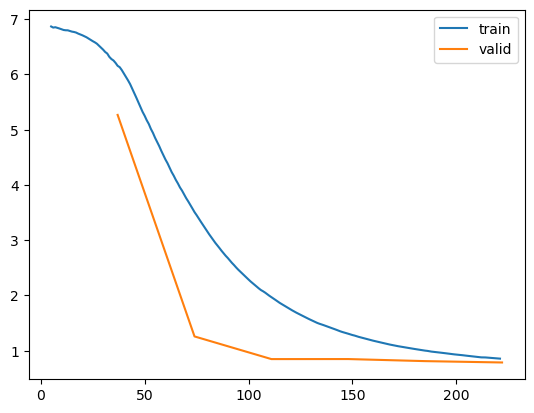

In [59]:
learn.recorder.plot_loss()

In [20]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop

In [21]:
learn = Learner(dls, resnet18(), metrics=accuracy, loss_func=nn.CrossEntropyLoss())
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.757854,0.786817,0.483146,00:52


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.723639,0.706813,0.488764,00:52
1,0.716669,0.727075,0.426966,00:52
2,0.708337,0.763661,0.477528,00:52
3,0.690957,0.733122,0.488764,00:53


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio obje

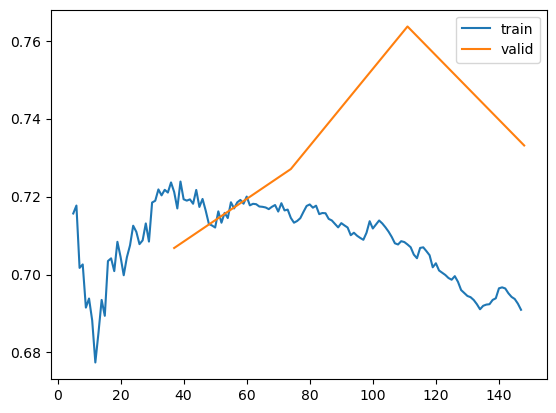

In [22]:
learn.recorder.plot_loss()

### Training is prohibitively slow using this approach. 

Could be due to :
- Custom AudioDatasetWrapper or other code containing python inefficiencies which should be replaced with tensor operations. OpenSoundScape provides its own collate function for getting tuple of tensors from an AudioFileDataset. Tried using this but needs further work. 
- It could be that the process of converting a clip to a spectrogram is just slow, in which case a speedup is possible by precomputing spectrograms. This was tested at the start of the project and it did result in a fast training cycle. 

on a subset of 800 spectrograms, the training loop takes about 1m20 per epoch, and the loss improves on both the training and the validation set during training. We can see the coarse nature of the data as one sample from the validation set gets classified differently causing a tiny increase in accuracy. 

It takes 4m41s to train 4 epochs on 800 spectrograms. The loss measured on the validation set does improve over time, as does the loss measured on the training set, but these improvements don't seem to affect the classification accuracy metric much. This suggests that either the accuracy metric or the loss functiion might not be working correctly, or just that the model isn't learning anything. First I'll check the metrics and loss then try improving the dataset. 

## Check the accuracy metric

In [23]:
# re-make dataloaders without greyscale to rgb conversion
wrapped_train_ds = AudioDatasetWrapper(train_dataset, greyscale_to_rgb=True)
wrapped_valid_ds = AudioDatasetWrapper(valid_dataset, greyscale_to_rgb=True)
train_dl = DataLoader(wrapped_train_ds,shuffle=True, bs=16)
valid_dl = DataLoader(wrapped_valid_ds, bs=16)
dls = DataLoaders(train_dl, valid_dl, device="mps")
dls.one_batch()[1].shape # label shape

torch.Size([16])

In [24]:
x,y = dls.one_batch()
inp = learn.model(x)
targ = y
inp, y

(tensor([[ 5.7847,  6.1585, -5.6448,  ..., -5.9970, -5.7239, -5.6750],
         [ 6.6197,  6.7599, -6.4304,  ..., -6.2597, -6.4619, -6.2872],
         [ 7.3497,  7.1134, -7.8328,  ..., -7.3719, -8.0333, -7.2749],
         ...,
         [ 6.5270,  6.5430, -6.3705,  ..., -6.2934, -6.4091, -6.2106],
         [ 7.5817,  7.4552, -8.2017,  ..., -7.6165, -8.3686, -7.5765],
         [ 5.5994,  5.8586, -5.3682,  ..., -5.7009, -5.5313, -5.3848]],
        device='mps:0', grad_fn=<LinearBackward0>),
 tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1], device='mps:0'))

In [25]:
learn.model(x).shape

torch.Size([16, 1000])

It looks as though the model loaded in the learner isn't fine tuned for this task yet, as evidenced by the 1000 activations returned by the model's forward method (it should only be returning 2). Let's explicitly remove the head of the model and replace with a 2 class head for this task. 

In [26]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2, device='mps')
learner = Learner(dls, model, metrics=accuracy, loss_func=nn.CrossEntropyLoss())
learner.fit_one_cycle(4, 1e-3)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.816085,0.984924,0.494382,00:52
1,0.757822,0.715771,0.455056,00:52
2,0.724102,0.700347,0.387640,00:52
3,0.717141,0.711055,0.500000,00:52


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio obje

The model outputs 2 values, one for each class. The loss funciton is crossentropy loss, which performs a softmax activation across both classes, providing a probability output for each class. Then the target is used to index into the class activations to identify the correct activation for a given example. The loss is calculated from the difference between the target and the activation, such that the closer the activations are to that set of targets, the lower the loss. The accuracy metric is calculated by taking the argmax of the activations, and comparing this to the target. 

In [27]:
nn.CrossEntropyLoss(reduction='none')(inp, targ)

tensor([0.5279, 0.7668, 0.8184, 0.0659, 0.7335, 0.8305, 0.8169, 0.5349, 0.5110,
        0.6707, 0.5184, 0.6259, 0.6616, 0.6865, 0.6320, 0.5790],
       device='mps:0', grad_fn=<NllLossBackward0>)

This is the loss contribution per example. These are averaged by default to get the loss for the batch.

In [28]:
nn.CrossEntropyLoss()(inp, targ)

tensor(0.6237, device='mps:0', grad_fn=<NllLossBackward0>)

In [29]:
nn.CrossEntropyLoss()(inp, y) == CrossEntropyLossFlat()(inp, y)

TensorBase(True, device='mps:0')

#  Try using the opensoundscape custom collate function

This might be quicker due to the use of tensor operations rather than python loops.

__collate_audio_samples_to_tensors__ takes a list of AudioSamples and batches them into tensors. This is the behaviour we need to be able to pass the dataset to a fastai learner.

In [30]:
collate_test = opso.ml.utils.collate_audio_samples_to_tensors([train_dataset[i] for i in range(5)])

collate_test[0].shape, collate_test[1].shape

(torch.Size([5, 1, 224, 672]), torch.Size([5, 2]))

In [31]:
collate_test[1]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

#### Difference in target dimension

The leading dimension is the batch dimension. The 2 dimensional target highlights that the data is structured with two target classes: 'present' and 'absent'. Since we're currently only using these two classes, the data could be represented with only one of these classes since the presence of one always indicates the absence of the other. 


### Multi class
providing multiple labels for the classifier to differentiate between could help with performance - a class for 'other bird' 'target bird', 'background' are all derivable from this dataset. 

#### Loss function
The loss function needs to be designed to have smooth gradients as the parameters are changed. Accuracy as measured by the number of correct IDs is suitable for use as a human readable metric, but can't serve as a loss function due to the sudden jumps in integer numbers of correct ids. 

The loss function needs to show that a prediction was slightly better or worse for a small change in parameters. In addition it may need to have a weighting to account for the upsampling or undersampling of classes within the training dataset. 


Different loss functions also require different shaped targets, some need the scores from each target to sum to 1 (Cross Entropy Loss), and some (Binary Cross Entropy) can work on one hot encoded targets and handle multiple positive labels per example. 

In [32]:
# Possible choices for the loss function. 
nn.CrossEntropyLoss
nn.BCELoss
nn.BCEWithLogitsLoss
# opso class aware loss

torch.nn.modules.loss.BCEWithLogitsLoss

In [33]:
train_dataset.class_counts()

(Index(['target_presence', 'target_absence'], dtype='object'),
 array([293., 293.]))

In [34]:
train_dataset.label_df.sample(5)

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-292508.mp3,4.5,7.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-295290.mp3,3.0,6.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-554028.flac,7.5,10.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-50047.flac,124.5,127.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-552869.flac,51.0,54.0,0.0,1.0


In [35]:
# def collate_audio_samples_to_float_tensor(batch):
#     tensors = torch.stack([i.data for i in batch])
#     labels = torch.tensor([i.labels.tolist() for i in batch])
#     return tensors, labels


In [36]:
train_dataloader = DataLoader(
    train_dataset,
    bs=16,
    shuffle=True,
    create_batch = opso.ml.utils.collate_audio_samples_to_tensors,
)
valid_dataloader = DataLoader(
    valid_dataset,
    bs=16,
    shuffle=False,
    create_batch = opso.ml.utils.collate_audio_samples_to_tensors,
)


In [37]:
type(valid_dataloader.one_batch())

tuple

Passing `create_batch = opso.ml.utils.collate_audio_samples_to_tensors` into `DataLoader` gives the expected behaviour of returning a tuple containing tensor spectrograms and their labels.

In [38]:
dls = DataLoaders(train_dataloader,valid_dataloader, device="mps")

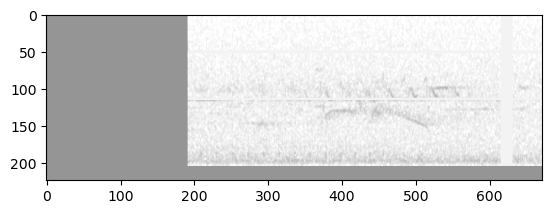

In [39]:
# training set spectrograms have augmentations:
show_tensor(dls.train.one_batch()[0].cpu()[0])

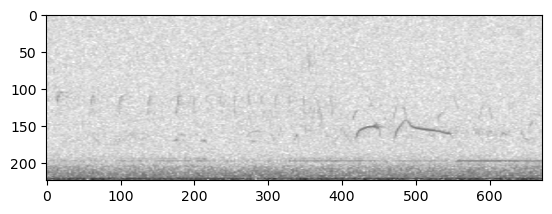

In [40]:
# no augmentations on the validation set:
show_tensor(dls.valid.one_batch()[0].cpu()[0])

### Check shape of input labels

In [41]:
x, y = dls.one_batch()
x.shape, y.shape
x.device, y.device, x.dtype, y.dtype

(device(type='mps', index=0),
 device(type='mps', index=0),
 torch.float32,
 torch.float32)

# Create a model

### Try importing the model from timm
The timm library should handle this channel mismatch by adding the weights from each of the channels into one greyscale channel. Another approach is to duplicate the channels in the greyscale image to create a 3 channel image by using torch.stack or tensor.repeat.

custom model https://forums.fast.ai/t/fastai-v2-pretrained-unet-with-different-number-of-channels/85776

In [42]:
model = timm.create_model('resnet18',pretrained=True, in_chans=1, num_classes=2)

Choose a suitable loss function for the input and target shapes.

In [43]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat())


In [44]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,time


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)


In [45]:
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([293., 293.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([89., 89.])))

Training takes 4m17s for a sample of 608 training samples and 130 validation samples. 

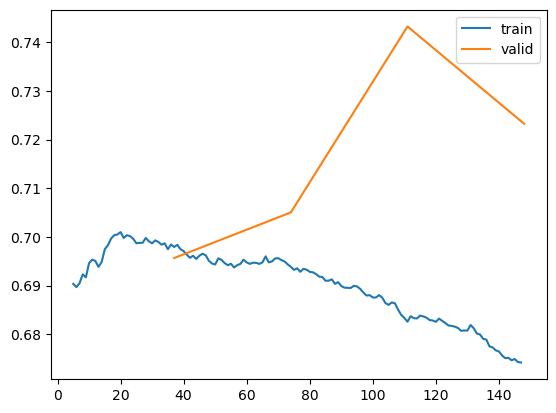

In [46]:
learn.recorder.plot_loss()

In [47]:
xb, yb = dls.one_batch()
xb.shape, yb.shape
model(xb).shape, yb.shape

(torch.Size([16, 2]), torch.Size([16, 2]))

In [48]:
learn.summary()

ResNet (Input shape: 16 x 1 x 224 x 672)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 336 
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 56 x 168  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                          

During training I got the following error:

`PreprocessingError: failed to preprocess sample from path: ../../data/raw/recordings/OSFL/recording-104149.mp3`

try setting out_of_bounds_ok=True in Spectrogram or cleaning out these samples

There doesn't seem to be anything wrong with the recording - it's a 10 minute mp3 file. During preprocessing there's a bandpass operation which seems to fail for this sample. The error can be replecated by setting the upper bandpass frequency too high - higher than any of the frequencies in the spectrogram data. It makes sense that this should throw an error: cutting out frequencies which do not exist is meaningless.

Why is this happening for this sample when it otherwise looks normal?

In [49]:
# error = opso.Audio.from_file('../../data/raw/recordings/OSFL/recording-104149.mp3')
# spec = opso.Spectrogram.from_audio(error)
# bandpass_spec = spec.bandpass(100, 9000, out_of_bounds_ok=False)
# bandpass_spec.plot(), spec.frequencies

In [50]:
problematic_path = Path("../../data/raw/recordings/OSFL/recording-104149.mp3")
multi_df = train_dataset.label_df
multi_df.index[0][0], problematic_path

(Path('../../data/raw/recordings/OSFL/recording-4539.mp3'),
 Path('../../data/raw/recordings/OSFL/recording-104149.mp3'))

In [51]:
multi_df

target_presence  \
file                                                 start_time end_time                    
../../data/raw/recordings/OSFL/recording-4539.mp3    12.0       15.0                  1.0   
../../data/raw/recordings/OSFL/recording-4787.mp3    7.5        10.5                  1.0   
                                                     9.0        12.0                  1.0   
                                                     78.0       81.0                  1.0   
                                                     79.5       82.5                  1.0   
...                                                                                   ...   
../../data/raw/recordings/OSFL/recording-295496.mp3  0.0        3.0                   0.0   
../../data/raw/recordings/OSFL/recording-321029.mp3  0.0        3.0                   0.0   
../../data/raw/recordings/OSFL/recording-292650.mp3  69.0       72.0                  0.0   
../../data/raw/recordings/OSFL/recording-297184.mp3  0.0        3.0                   0.0   
../../data/raw/recordings/OSFL/recording-555544.flac 9.0        12.0                  0.0   

                                                                          target_absence  
file                                                 start_time end_time                  
../../data/raw/recordings/OSFL/recording-4539.mp3    12.0       15.0                 0.0  
../../data/raw/recordings/OSFL/recording-4787.mp3    7.5        10.5                 0.0  
                                                     9.0        12.0                 0.0  
                                                     78.0       81.0                 0.0  
                                                     79.5       82.5                 0.0  
...                                                                                  ...  
../../data/raw/recordings/OSFL/recording-295496.mp3  0.0        3.0                  1.0  
../../data/raw/recordings/OSFL/recording-321029.mp3  0.0        3.0                  1.0  
../../data/raw/recordings/OSFL/recording-292650.mp3  69.0       72.0                 1.0  
../../data/raw/recordings/OSFL/recording-297184.mp3  0.0        3.0                  1.0  
../../data/raw/recordings/OSFL/recording-555544.flac 9.0        12.0                 1.0  

[586 rows x 2 columns]

### Check what order the preprocessing happens in opso


In [52]:
train_dataset.preprocessor.pipeline

load_audio                              Action calling <bound method Audio.from_file of <class 'opensoundscape.audio.Audio'>>
random_trim_audio                                            Augmentation Action calling <function trim_audio at 0x169c425f0>
trim_audio                                                                Action calling <function trim_audio at 0x169c425f0>
to_spec              Action calling <bound method Spectrogram.from_audio of <class 'opensoundscape.spectrogram.Spectrogram'>>
bandpass                                                        Action calling <function Spectrogram.bandpass at 0x157e88e50>
to_tensor                                                                                                              Action
time_mask                                                     Augmentation Action calling <function time_mask at 0x169c436d0>
frequency_mask                                           Augmentation Action calling <function frequency_mask at 0x169

If we preprocess the spectrograms and save them to disk, we lose the flexibility to easily switch between different spectrogram parameter settings. Mixup would be affected too, since this should be applied at the audio level. The rest of the hyperparameters would be applicable to a preprocessed spectrogram. 


In [53]:
# osfl_dl = DataLoader(training_dataset, bs=16, before_batch = custom_collate)
# osfl_dl.one_batch()

# Conclusion

Based on the training curves shown above, it looks as though the model is learning something, but this isn't enough to affect the acccuracy metric and cause classification changes for either class. 

Further work will be to improve the quality of the dataset as much as possible:

- increase the number of positive examples
- create a buffer area next to the positive example so that any segments of audio which contan a part of the target species call are not in the training set. 
- Change the spectrogram parameters so that the spectrograms contain clearer images. 